In [1]:
!pip install torch torchvision timm kaggle
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download shuvoalok/raf-db-dataset
!unzip raf-db-dataset.zip -d data/
!rm raf-db-dataset.zip
!mkdir raf-db-dataset
import os
import shutil
import random
from tqdm import tqdm

def split_train_val(source_dir, val_dir, val_ratio=0.1):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)
        val_count = int(len(images) * val_ratio)

        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in tqdm(images[:val_count], desc=f"Moving to val/{class_name}"):
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(val_class_dir, img)
            shutil.move(src_path, dst_path)

# Kullanım:
split_train_val('/content/data/DATASET/train', '/content/data/DATASET/val', val_ratio=0.1)
!mv data/DATASET/test/ raf-db-dataset//
!mv data/DATASET/train/ raf-db-dataset//
!mv data/DATASET/val/ raf-db-dataset//

Streaming output truncated to the last 5000 lines.
  inflating: data/DATASET/train/5/train_00987_aligned.jpg  
  inflating: data/DATASET/train/5/train_00990_aligned.jpg  
  inflating: data/DATASET/train/5/train_00991_aligned.jpg  
  inflating: data/DATASET/train/5/train_00992_aligned.jpg  
  inflating: data/DATASET/train/5/train_01002_aligned.jpg  
  inflating: data/DATASET/train/5/train_01010_aligned.jpg  
  inflating: data/DATASET/train/5/train_01011_aligned.jpg  
  inflating: data/DATASET/train/5/train_01013_aligned.jpg  
  inflating: data/DATASET/train/5/train_01015_aligned.jpg  
  inflating: data/DATASET/train/5/train_01017_aligned.jpg  
  inflating: data/DATASET/train/5/train_01039_aligned.jpg  
  inflating: data/DATASET/train/5/train_01048_aligned.jpg  
  inflating: data/DATASET/train/5/train_01049_aligned.jpg  
  inflating: data/DATASET/train/5/train_01053_aligned.jpg  
  inflating: data/DATASET/train/5/train_01070_aligned.jpg  
  inflating: data/DATASET/train/5/train_01074_ali

Moving to val/3: 100%|██████████| 71/71 [00:00<00:00, 34663.67it/s]


In [2]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])


train_data = datasets.ImageFolder("/content/raf-db-dataset/train", transform=transform)
val_data = datasets.ImageFolder("/content/raf-db-dataset/val", transform=transform)
test_data = datasets.ImageFolder("/content/raf-db-dataset/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)


In [4]:
from torchvision.models import inception_v3, Inception_V3_Weights

# Use latest recommended API
weights = Inception_V3_Weights.DEFAULT
inception = inception_v3(weights=weights, aux_logits=True)

# Freeze backbone
for param in inception.parameters():
    param.requires_grad = False

# Replace classifier
in_features = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_data.classes))
)

inception = inception.to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 193MB/s] 


In [5]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.fc.parameters(), lr=1e-3)


In [9]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            if isinstance(outputs, tuple):  # for InceptionV3
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.4642 | Train Acc: 0.4440 | Val Acc: 0.4702
Epoch 2/10 | Avg Loss: 1.4362 | Train Acc: 0.4558 | Val Acc: 0.4963
Epoch 3/10 | Avg Loss: 1.4207 | Train Acc: 0.4677 | Val Acc: 0.4898
Epoch 4/10 | Avg Loss: 1.3960 | Train Acc: 0.4711 | Val Acc: 0.5029
Epoch 5/10 | Avg Loss: 1.3939 | Train Acc: 0.4701 | Val Acc: 0.5102
Epoch 6/10 | Avg Loss: 1.3866 | Train Acc: 0.4735 | Val Acc: 0.5102
Epoch 7/10 | Avg Loss: 1.3791 | Train Acc: 0.4775 | Val Acc: 0.4939
Epoch 8/10 | Avg Loss: 1.3718 | Train Acc: 0.4794 | Val Acc: 0.4988
Epoch 9/10 | Avg Loss: 1.3621 | Train Acc: 0.4875 | Val Acc: 0.5118
Epoch 10/10 | Avg Loss: 1.3520 | Train Acc: 0.4922 | Val Acc: 0.5184


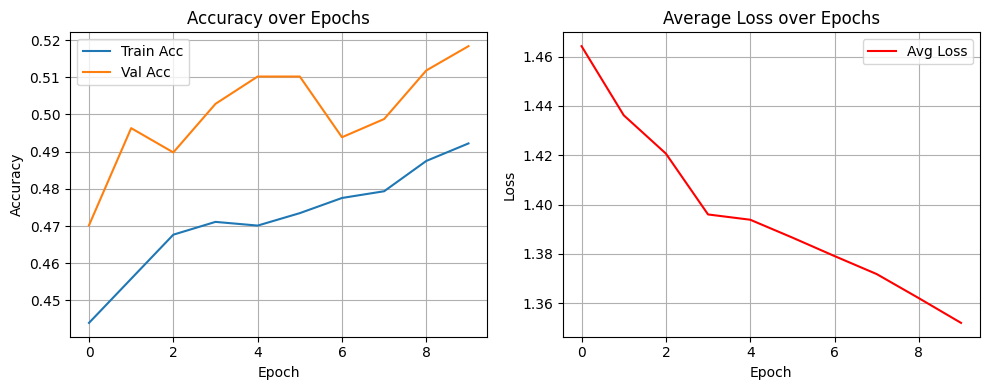

In [10]:
inception = train_model(inception, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.4774

              precision    recall  f1-score   support

           1       0.58      0.45      0.51       329
           2       0.47      0.43      0.45        74
           3       0.12      0.01      0.01       160
           4       0.53      0.85      0.65      1185
           5       0.47      0.29      0.36       478
           6       0.69      0.06      0.10       162
           7       0.50      0.39      0.44       680

    accuracy                           0.52      3068
   macro avg       0.48      0.35      0.36      3068
weighted avg       0.51      0.52      0.48      3068



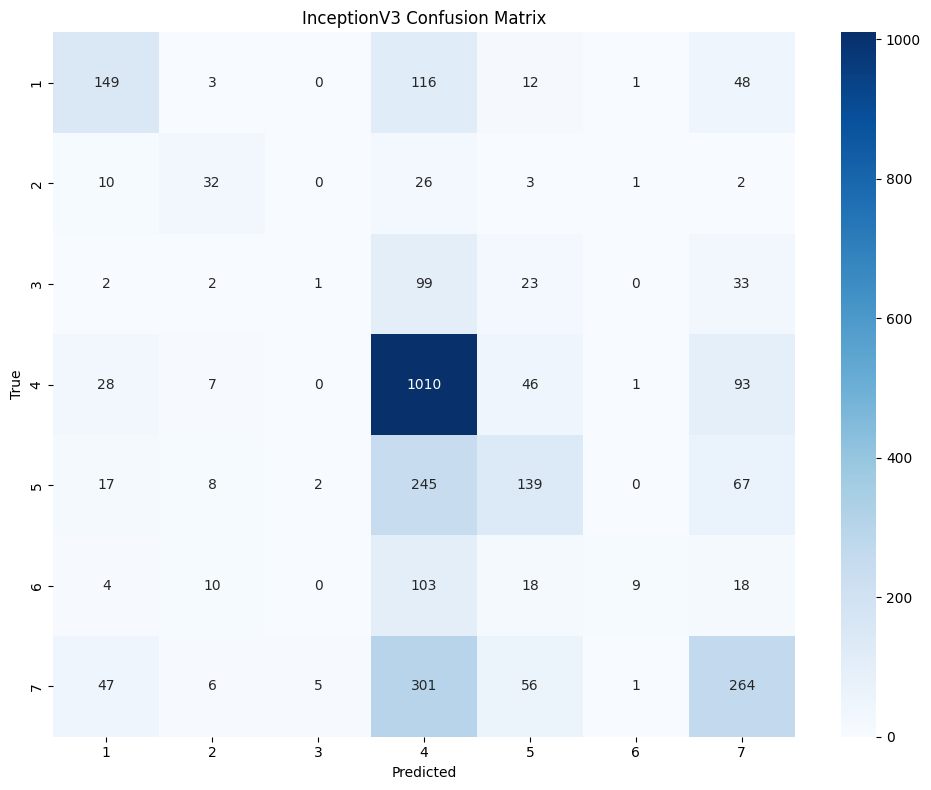

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Switch to eval mode
inception.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
